In [361]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xinwangcs/stressor-cause-of-mental-health-problem-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\xinwangcs\stressor-cause-of-mental-health-problem-dataset\versions\1


In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
FILES = []
for file in os.listdir(path):
    if file.endswith(".json"):
        PATH = os.path.join(path, file)
        FILES.append(PATH )
#print("Files in dataset:", FILES)



In [363]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [364]:
import json

def load_data2dataframe(file):
    """
    讀取 JSON 文件並將其轉換為 Pandas DataFrame。
    參數:
        file (str): 檔案路徑。

    錯誤回報:
        ValueError: 如果在資料集目錄中找不到 JSON 檔案。
        ValueError: 如果指定的 JSON 檔案不存在。
        
    回傳:
        pd.DataFrame: 包含文本、壓力源類別、壓力源詞和時間間隔的 DataFrame。
    """
    if not FILES:
        raise ValueError("No JSON files found in the dataset directory.")
    if not os.path.exists(file):
        raise ValueError(f"File '{file}' does not exist.")
    with open(file, encoding="utf-8") as f:
        data = json.load(f)
        if not isinstance(data, list):
            raise ValueError(f"Expected a list in JSON file, got {type(data)}")
        temp = []
        for item in data:
            #print(item)
            TEXT = item["text"]
            INTERVAL = item["interval"]
            try:
                STRESSOR_class = item["labels"][0][0]
                STRESSOR_WORD = item["labels"][0][4]
            except IndexError:
                STRESSOR_class = np.nan
                STRESSOR_WORD = np.nan
            temp.append((TEXT, STRESSOR_class, STRESSOR_WORD, INTERVAL))

    # Convert list of tuples to DataFrame with column names
    return pd.DataFrame(temp, columns=["text", "stressor_class", "stressor_word", "interval"])

dataframes = [load_data2dataframe(f) for f in FILES]
df = pd.concat(dataframes, ignore_index=True)
df.head()

,text,stressor_class,stressor_word,interval
0,Why are there always trivial matters in life t...,T1,financial,8
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8
2,"In the coming March, my work pressure will be ...",T1,work,8
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8


In [365]:
df.dropna(inplace=True)
df.isna().sum()

text              0
stressor_class    0
stressor_word     0
interval          0
dtype: int64

In [366]:
df_copy = df.copy()

In [367]:
import spacy

nlp = spacy.load("en_core_web_sm")

def normalize_spacy(text):
    '''
    將文本轉換為小寫,並移除標點符號、空白和停用詞，在進行詞型還原。
    '''
    doc = nlp(text.lower())
    lemmatized = []
    for token in doc:
        if token.is_punct or token.is_space or token.is_stop:
            continue
        lemma = token.lemma_
        lemmatized.append(lemma)
    return lemmatized

print(normalize_spacy("everyone myself others I around me, urged to marry the cats and dogs"))


['urge', 'marry', 'cat', 'dog']


In [368]:
from gensim import corpora
from gensim.models.tfidfmodel import TfidfModel
# 1. 文字正規化
texts = [normalize_spacy(doc) for doc in df_copy["stressor_word"]]

# 2. 過濾空文本（避免 dictionary 出錯）
df_copy["normalized"] = texts
df_copy = df_copy[df_copy["normalized"].apply(lambda x: len(x) > 0)].reset_index(drop=True)

# 3. 建立字典
texts = df_copy["normalized"].tolist()
dictionary = corpora.Dictionary(texts)

# 4. 記錄原始 token 數量（同步前）
original_token_ids = set(dictionary.token2id.keys())

# 5. 過濾太少／太常見詞
dictionary.filter_extremes(no_below=2, no_above=0.5)

# 6. 建立新語料（這時候 dictionary ID 是新的）
corpus = [dictionary.doc2bow(text) for text in texts]
# # 7. 轉換 Tfidf 格式
# tfidf = TfidfModel(corpus)
# corpus = [tfidf[text_corpus] for text_corpus in corpus]

In [369]:
empty_indices = [i for i, doc in enumerate(corpus) if not doc]
print(empty_indices)

[9, 14, 33, 57, 59, 80, 120, 140, 147, 149, 162, 175, 188, 190, 197, 213, 216, 253, 286, 290, 302, 313, 321, 330, 338, 355, 365, 373, 381, 383, 468, 472, 490, 501, 509, 516, 546, 562, 592, 690, 693, 697, 698, 701, 757, 769, 776, 789, 846, 857, 932, 951, 984, 985, 993, 995, 997, 1006, 1008, 1025, 1041, 1043, 1062, 1073, 1084, 1119, 1140, 1149, 1162, 1170, 1175, 1182, 1201, 1215, 1217, 1219, 1226, 1240, 1253, 1271, 1294, 1328, 1333, 1339, 1397, 1410, 1412, 1430, 1446, 1456, 1474, 1487, 1489, 1512, 1527, 1552, 1555, 1561, 1574, 1576, 1586, 1603, 1605, 1616, 1637, 1642, 1648, 1677, 1712, 1713, 1728, 1734, 1750, 1762, 1776, 1783, 1787, 1788, 1846, 1864, 1865, 1889, 1892, 1940, 1948, 1958, 1959, 1974, 1978, 1980, 2007, 2014, 2016, 2025, 2026, 2042, 2043, 2057, 2069, 2075, 2082, 2089, 2096, 2097, 2105, 2124, 2159, 2161, 2165, 2168, 2191, 2192, 2201, 2205, 2224, 2235, 2255, 2277, 2284, 2344, 2357, 2359, 2367, 2368, 2373, 2376, 2380, 2408, 2410, 2418, 2435, 2437, 2439, 2445, 2446, 2450, 2457, 2

In [370]:
# 刪除 corpus_TFiDF 中 empty_indices 對應的元素
corpus = [doc for i, doc in enumerate(corpus) if i not in empty_indices]

In [371]:
try:
    df_copy.drop(empty_indices, inplace=True)
except:
    pass

In [372]:
len(df_copy) , len(corpus)

(3600, 3600)

計算最佳主題數 4群 泛化能力稍佳
---

In [373]:
# from gensim.models import CoherenceModel, LdaModel

# def train_and_compute_coherence(
#     dictionary, corpus, texts,coherence_type, start=2, limit=10):
#     values = []
#     for num_topics in range(start, limit + 1):
#         model = LdaModel(
#             corpus=corpus,
#             id2word=dictionary,
#             num_topics=num_topics,
#             alpha='auto',
#             eta='auto',
#             passes=10
#         )
#         coherence_model = CoherenceModel(
#             model=model,
#             texts=texts,
#             dictionary=dictionary,
#             coherence=coherence_type
#         )
#         values.append(coherence_model.get_coherence())
#     return values

# all_runs =  []
# for i in range(1,6):
#     scores = train_and_compute_coherence(
#         dictionary, 
#         corpus_tfidf, 
#         texts, 
#         coherence_type = 'c_v', 
#         start = 2, 
#         limit = 10
#     )
#     all_runs.append(scores)


In [374]:
# import numpy as np
# avg_values = np.mean(all_runs, axis=0) 

In [375]:
# np.argmax(all_runs , axis=1)+2

In [376]:

# x = range(2,11)
# plt.plot(x, avg_values)
# plt.title("Optimal Number of Topics")
# plt.grid(axis="x" , linestyle='--')
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score")
# plt.show()

模型建立-進行主題分群
---

In [412]:
from gensim.models.ldamodel import LdaModel
# 建立 LDA 模型
lda_model = LdaModel(corpus=corpus, 
                     id2word=dictionary, 
                     num_topics=4, # (3 or 4)
                     passes=60,
                     random_state=42
                )

# 取得每筆資料的主題分佈
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# 取最大主題編號作為群標籤
topic_labels = [max(dist, key=lambda x: x[1])[0] for dist in topic_distributions]

In [413]:
topic_words = lda_model.print_topics()
topic_words

[(0,
  '0.050*"celebrate" + 0.048*"examination" + 0.026*"psychological" + 0.022*"admission" + 0.021*"exam" + 0.021*"damage" + 0.018*"graduate" + 0.017*"responsible" + 0.015*"dear" + 0.014*"expect"'),
 (1,
  '0.015*"marry" + 0.015*"video" + 0.013*"early" + 0.012*"hear" + 0.012*"excel" + 0.011*"stay" + 0.011*"like" + 0.011*"financial" + 0.009*"eager" + 0.009*"high"'),
 (2,
  '0.219*"freedom" + 0.109*"german" + 0.022*"peace" + 0.020*"family" + 0.019*"feel" + 0.017*"heart" + 0.009*"energetic" + 0.007*"entrance" + 0.006*"twenty" + 0.006*"unfold"'),
 (3,
  '0.068*"personal" + 0.044*"time" + 0.014*"advice" + 0.012*"irreparable" + 0.012*"fortunate" + 0.011*"leave" + 0.009*"concern" + 0.009*"find" + 0.009*"tomorrow" + 0.008*"show"')]

In [414]:
import re

# 取得主題與描述
topics = lda_model.print_topics()

# 只擷取每個主題中的詞（不含機率）
topic_keywords = [re.findall(r'"(.*?)"', topic[1]) for topic in topics]

# 若想加上主題編號
topic_words = []
for idx, words in enumerate(topic_keywords):
    topic_words.append(words)



In [416]:
# 展平所有詞
all_words = [word for topic in topic_keywords for word in topic]
distinct_words = set(all_words)

kword = 10  # 每個主題取 10 個詞
Term = 4  # 共有 4 個主題
diversity = len(distinct_words) / (kword* Term)

print(f"Topic Diversity = {diversity:.3f}")



Topic Diversity = 1.000


In [417]:
df_copy["topic"] = topic_labels
df_copy.head(10)

,text,stressor_class,stressor_word,interval,normalized,topic
0,Why are there always trivial matters in life t...,T1,financial,8,[financial],0
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8,"[urge, marry]",3
2,"In the coming March, my work pressure will be ...",T1,work,8,[work],2
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8,[paper],0
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8,[learn],0
5,Staying up late is irreparable damage. I've st...,T1,learn,8,[learn],0
6,Watching decompressing videos on Douyin increa...,T1,decompressing videos,8,"[decompress, video]",2
7,The pressure from scrolling through Xiaohongsh...,T1,Xiaohongshu,8,[xiaohongshu],1
8,I'm out of money... the baby clothing store is...,T1,baby clothing store,8,"[baby, clothing, store]",2
10,All the pressure and obstacles are given by my...,T1,my family,8,[family],2


In [418]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X = df_copy["text"]
y = df_copy["topic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , stratify=y)


In [419]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
texts = [normalize_spacy(word) for word in X]
dictionary = Dictionary(texts)

X_train_tokens = [normalize_spacy(text) for text in X_train]
X_test_tokens = [normalize_spacy(text) for text in X_test]

X_train_vectorized = [dictionary.doc2bow(text) for text in X_train_tokens]
X_test_vectorized = [dictionary.doc2bow(text) for text in X_test_tokens]


tfidf_model = TfidfModel(X_train_vectorized)
X_train_tfidf = [tfidf_model[doc] for doc in X_train_vectorized]
X_test_tfidf = [tfidf_model[doc] for doc in X_test_vectorized]


In [420]:
from gensim import matutils
import numpy as np

# 將稀疏向量轉成稠密矩陣
def bow_to_dense(corpus, dictionary):
    return np.array([
        matutils.corpus2dense([bow], num_terms=len(dictionary)).T[0]
        for bow in corpus
    ])

X_train_vectorized = bow_to_dense(X_train_tfidf, dictionary)
X_test_vectorized = bow_to_dense(X_test_tfidf, dictionary)


# 模型比對


linear-SVC
---

In [421]:
from sklearn.svm import LinearSVC
SVC_model = LinearSVC(
                        penalty="l1" ,
                        class_weight="balanced",
                        random_state=42
                    )
SVC_model.fit(X_train_vectorized, y_train)  
y_pred = SVC_model.predict(X_test_vectorized)  
print(SVC_model.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.725
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       161
           1       0.65      0.60      0.63       124
           2       0.80      0.79      0.79       290
           3       0.70      0.72      0.71       145

    accuracy                           0.72       720
   macro avg       0.71      0.70      0.71       720
weighted avg       0.72      0.72      0.72       720



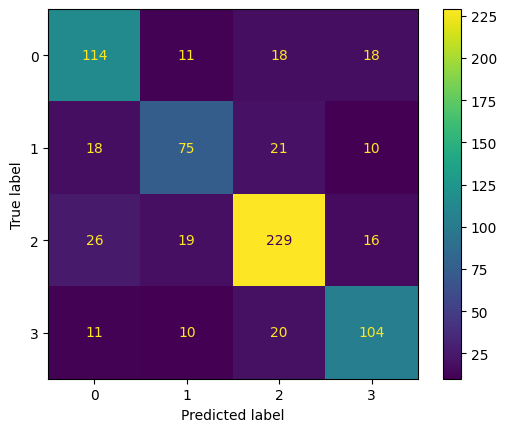

In [422]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(SVC_model, X_test_vectorized, y_test)
plt.show()

LogisticRegression
---

In [423]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(class_weight="balanced")
LR.fit(X_train_vectorized, y_train)  
y_pred = LR.predict(X_test_vectorized)  
print(LR.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.7125
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       161
           1       0.59      0.59      0.59       124
           2       0.79      0.79      0.79       290
           3       0.70      0.70      0.70       145

    accuracy                           0.71       720
   macro avg       0.69      0.69      0.69       720
weighted avg       0.71      0.71      0.71       720



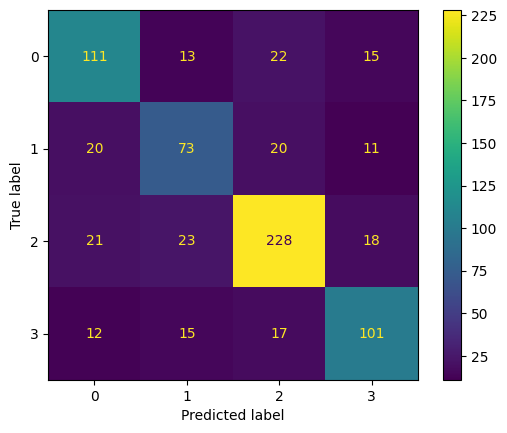

In [424]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(LR, X_test_vectorized, y_test)
plt.show()

SGDClassifier
---

In [425]:
from sklearn.linear_model import SGDClassifier 
SGD = SGDClassifier(
                    penalty="elasticnet", 
                    class_weight="balanced",
                    random_state=42 
                )
SGD.fit(X_train_vectorized, y_train)  
y_pred = SGD.predict(X_test_vectorized)  
print(SGD.score(X_test_vectorized,y_test))
print(classification_report(y_test, y_pred))

0.6930555555555555
              precision    recall  f1-score   support

           0       0.59      0.77      0.67       161
           1       0.66      0.48      0.55       124
           2       0.79      0.77      0.78       290
           3       0.66      0.64      0.65       145

    accuracy                           0.69       720
   macro avg       0.68      0.66      0.66       720
weighted avg       0.70      0.69      0.69       720



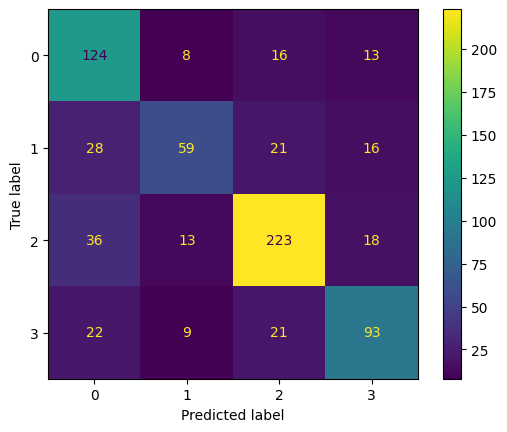

In [426]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(SGD, X_test_vectorized, y_test)
plt.show()

交叉驗證-1
---

In [427]:
from sklearn.model_selection import cross_val_score

print("LR : " , cross_val_score(LR, X_test_vectorized, y_test, cv=5).mean())
print("SVC : ",cross_val_score(SVC_model, X_test_vectorized, y_test, cv=5).mean())
print("SGD : ",cross_val_score(SGD, X_test_vectorized, y_test, cv=5).mean())

LR :  0.5694444444444444
SVC :  0.6069444444444445
SGD :  0.5638888888888889


# 超參數搜尋

linear-svc
---

In [429]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

svc_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [1e-2 , 0.1 , 1 ,2 ,3],
    'tol': [1e-4, 1e-3]
}

svc_model = LinearSVC(random_state=42 , class_weight="balanced")
grid_svc = GridSearchCV(svc_model, svc_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train_vectorized, y_train)

print(grid_svc.best_score_)
print(grid_svc.best_params_)

0.715625
{'C': 1, 'penalty': 'l1', 'tol': 0.0001}


In [430]:
print(classification_report(y_test, grid_svc.predict(X_test_vectorized)))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69       161
           1       0.65      0.60      0.63       124
           2       0.80      0.79      0.79       290
           3       0.70      0.72      0.71       145

    accuracy                           0.72       720
   macro avg       0.71      0.70      0.71       720
weighted avg       0.72      0.72      0.72       720



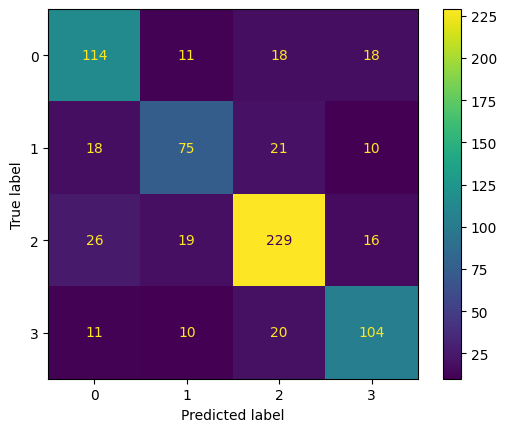

In [431]:
ConfusionMatrixDisplay.from_estimator(grid_svc.best_estimator_, X_test_vectorized, y_test)
plt.show()

logistic-regression
---

In [443]:
from sklearn.linear_model import LogisticRegression 

lr_param_grid = {
    'C': [1e-4, 1e-3, 1e-2, 0.1, 1],
    'tol': [1e-3, 1e-4],
    'l1_ratio': [0.5, 0.7, 0.9, 1.0]
}

lr_model = LogisticRegression(
                              penalty='l1',
                              class_weight='balanced',
                              solver='liblinear',
                              max_iter=1000,
                              random_state=42
                            )
grid_lr = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_vectorized, y_train)

print(grid_lr.best_score_)
print(grid_lr.best_params_)

0.7
{'C': 1, 'l1_ratio': 0.5, 'tol': 0.001}


c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [444]:
print(classification_report(y_test, grid_lr.predict(X_test_vectorized)))


              precision    recall  f1-score   support

           0       0.67      0.68      0.68       161
           1       0.55      0.60      0.58       124
           2       0.82      0.77      0.80       290
           3       0.68      0.70      0.69       145

    accuracy                           0.71       720
   macro avg       0.68      0.69      0.69       720
weighted avg       0.71      0.71      0.71       720



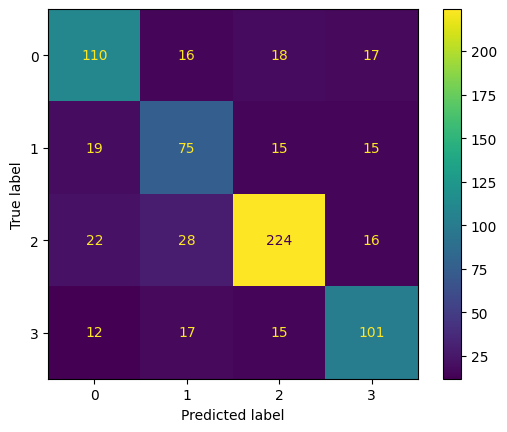

In [434]:
ConfusionMatrixDisplay.from_estimator(grid_lr.best_estimator_, X_test_vectorized, y_test)
plt.show()

SGDClassifier
---

In [446]:
from sklearn.linear_model import SGDClassifier

sgd_param_grid = {
    'penalty': ['elasticnet'],
    'alpha': [1e-4, 5e-4, 1e-3],
    'l1_ratio': [0.7, 0.9, 1.0],
    'class_weight': ['balanced'],
    'max_iter': [1000],
    'epsilon': [0.1],
    'tol' : [1e-3, 1e-2]
}


sgd_model = SGDClassifier(random_state=42)
grid_sgd = GridSearchCV(sgd_model, sgd_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_sgd.fit(X_train_vectorized, y_train)

print(grid_sgd.best_score_)
print(grid_sgd.best_params_)

0.7149305555555556
{'alpha': 0.0005, 'class_weight': 'balanced', 'epsilon': 0.1, 'l1_ratio': 0.7, 'max_iter': 1000, 'penalty': 'elasticnet', 'tol': 0.001}


In [436]:
print(classification_report(y_test, grid_sgd.predict(X_test_vectorized)))

              precision    recall  f1-score   support

           0       0.60      0.71      0.65       161
           1       0.69      0.51      0.59       124
           2       0.81      0.77      0.79       290
           3       0.65      0.72      0.68       145

    accuracy                           0.70       720
   macro avg       0.69      0.68      0.68       720
weighted avg       0.71      0.70      0.70       720



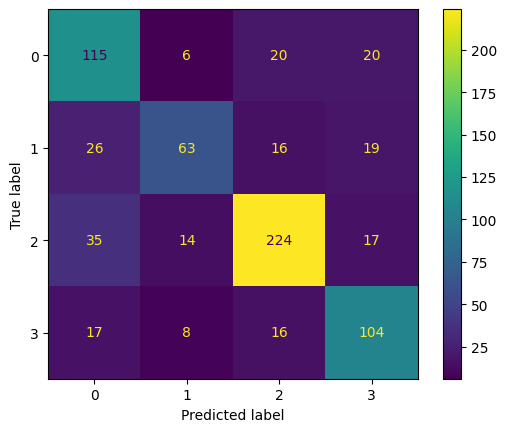

In [437]:
ConfusionMatrixDisplay.from_estimator(grid_sgd.best_estimator_, X_test_vectorized, y_test)
plt.show()

交叉驗證-2
---

In [447]:
models = [
            grid_svc.best_estimator_, 
            grid_lr.best_estimator_, 
            grid_sgd.best_estimator_,
        ]
for model in models:
    print(cross_val_score(model, X_train_vectorized, y_train, cv=5).mean())

0.715625


c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l

0.7
0.7149305555555556


predicted_topic

In [448]:
# 使用所有模型對 X_test_vectorized 進行預測並顯示準確率
from sklearn.metrics import accuracy_score
for model in models:
    y_pred = model.predict(X_test_vectorized)
    print(f"{model.__class__.__name__} accuracy: {accuracy_score( y_test,y_pred )}")

LinearSVC accuracy: 0.725
LogisticRegression accuracy: 0.7083333333333334
SGDClassifier accuracy: 0.7027777777777777


In [449]:
import joblib

# 存儲最佳模型
joblib.dump(grid_svc.best_estimator_, "best_linear_svc_model.joblib")
joblib.dump(grid_lr.best_estimator_, "best_logistic_regression_model.joblib")
joblib.dump(grid_sgd.best_estimator_, "best_sgd_classifier_model.joblib")

['best_sgd_classifier_model.joblib']